In [14]:
### Text Normalization/Cleansing
import re
import pandas as pd

#defination of data test, train, and validation
df = pd.read_csv("train_preprocess.txt", delimiter = "\t", header=None)

df.columns =['text', 'label']
sentiment = ['negative', 'neutral', 'positive']

#ChangeAlayPath
df_kbbi = pd.read_csv('KamusAlayIvan.csv', header=None, encoding='ISO-8859-1', names=['TIDAKBAKU', 'BAKU'])

In [15]:
df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [16]:

#DefinitionCleansingFunction
def removechars(text):
    text = re.sub(r'[^\w]', ' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))','',text)
    text = re.sub('\d', '', text)
    text = re.sub(r'\b\w\b', '', text)
###Stopwords in RemoveChars
    text = re.sub('di','',text)
    text = re.sub('yang','',text)
    text = re.sub('dan','',text)
    text = re.sub('nya','',text)
    text = re.sub('saya','',text)
    text = re.sub('ini','',text)
    text = re.sub('itu','',text)
    text = re.sub('aku','',text)
    text = re.sub('kamu','',text)
    text = re.sub('th','',text)
    return text

def changealay(text):
    alay = dict(zip(df_kbbi['TIDAKBAKU'], df_kbbi['BAKU']))
    text = ' '.join([alay[word] if word in alay else word for word in text.split(' ')])
    return text

In [17]:
def cleaning(text):
    text = removechars(text)
    text = changealay(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [18]:
df = pd.read_csv("train_preprocess.txt", delimiter = "\t", header=None)
df.columns =['text', 'label']
sentiment = ['negative', 'neutral', 'positive']

df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [19]:
df['text'] = df['text'].apply(cleaning)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(df['text'])

x = tfidf_vect.transform(df['text'])
print('Feature Extraction TFIDF Selesai')

Feature Extraction TFIDF Selesai


In [21]:
# Cek duplicate
df.duplicated().sum()
# Delete duplicate
df = df.drop_duplicates()
df.shape

(10931, 2)

In [22]:
df.label.value_counts()

label
positive    6382
negative    3412
neutral     1137
Name: count, dtype: int64

In [23]:
neg = df.loc[df['label'] == 'negative'].text.tolist()
neu = df.loc[df['label'] == 'neutral'].text.tolist()
pos = df.loc[df['label'] == 'positive'].text.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6382, Neu: 1137, Neg: 3412
Total data: 10931


In [24]:
### Feature Extraction

import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [25]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [26]:
### Prepare & Test Datasets/Splitting Dataset

from sklearn.model_selection import train_test_split

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [27]:
### Train

import numpy as np
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

# Hyperparameters
max_features = 100000
embed_dim = 128
units = 256

# Membuat model
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(units=units, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan model
print(model.summary())

# Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Melatih model
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

# Evaluasi model
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]}, Test accuracy: {score[1]}")

C:\Users\hivan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 445ms/step - accuracy: 0.5280 - loss: 1.0118 - val_accuracy: 0.6017 - val_loss: 0.7638
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 428ms/step - accuracy: 0.6453 - loss: 0.7751 - val_accuracy: 0.7554 - val_loss: 0.6104
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 441ms/step - accuracy: 0.7439 - loss: 0.6357 - val_accuracy: 0.7773 - val_loss: 0.5545
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 426ms/step - accuracy: 0.7662 - loss: 0.5762 - val_accuracy: 0.7842 - val_loss: 0.5156
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 434ms/step - accuracy: 0.7923 - loss: 0.5181 - val_accuracy: 0.8107 - val_loss: 0.4743
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 431ms/step - accuracy: 0.8039 - loss: 0.4870 - val_accuracy: 0.8390 - val_loss: 0.4409
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 435ms/step - accuracy: 0.8343 - loss: 0.4363 - val_accuracy: 0.8514 - val_loss: 0.4199
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 432ms/step - accuracy: 0.8509 - loss: 0.4024 - val

In [28]:
### Evaluation

from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       670
           1       0.81      0.69      0.74       223
           2       0.93      0.90      0.91      1294

    accuracy                           0.87      2187
   macro avg       0.84      0.82      0.83      2187
weighted avg       0.87      0.87      0.87      2187



In [29]:
### Cross Validation

# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

max_features = 100000
embed_dim = 128
units = 256
for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    # Membuat model
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=embed_dim, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.7))
    model.add(LSTM(units=units, dropout=0.7, recurrent_dropout=0.7))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Menampilkan ringkasan model
    print(model.summary())

    # Callbacks
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

    # Melatih model
    history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

C:\Users\hivan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 447ms/step - accuracy: 0.5182 - loss: 1.0227 - val_accuracy: 0.5958 - val_loss: 0.8088
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 460ms/step - accuracy: 0.6277 - loss: 0.7881 - val_accuracy: 0.7554 - val_loss: 0.6147
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 453ms/step - accuracy: 0.7300 - loss: 0.6715 - val_accuracy: 0.7732 - val_loss: 0.5579
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 451ms/step - accuracy: 0.7773 - loss: 0.5732 - val_accuracy: 0.7846 - val_loss: 0.5288
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 447ms/step - accuracy: 0.7791 - loss: 0.5365 - val_accuracy: 0.8171 - val_loss: 0.4924
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 441ms/step - accuracy: 0.8174 - loss: 0.4801 - val_accuracy: 0.8336 - val_loss: 0.4567
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 479ms/step - accuracy: 0.8250 - loss: 0.4508 - val_accuracy: 0.8519 - val_loss: 0.4219
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 449ms/step - accuracy: 0.8517 - loss: 0.4098 - val

C:\Users\hivan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 451ms/step - accuracy: 0.5317 - loss: 1.0139 - val_accuracy: 0.6260 - val_loss: 0.7530
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 436ms/step - accuracy: 0.6425 - loss: 0.7725 - val_accuracy: 0.7563 - val_loss: 0.6105
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 447ms/step - accuracy: 0.7402 - loss: 0.6392 - val_accuracy: 0.7750 - val_loss: 0.5570
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 442ms/step - accuracy: 0.7784 - loss: 0.5750 - val_accuracy: 0.7810 - val_loss: 0.5338
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 430ms/step - accuracy: 0.7946 - loss: 0.5252 - val_accuracy: 0.8294 - val_loss: 0.4789
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 427ms/step - accuracy: 0.8162 - loss: 0.4670 - val_accuracy: 0.8445 - val_loss: 0.4416
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 430ms/step - accuracy: 0.8331 - loss: 0.4455 - val_accuracy: 0.8496 - val_loss: 0.4221
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 434ms/step - accuracy: 0.8535 - loss: 0.3877 - val

C:\Users\hivan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 435ms/step - accuracy: 0.5411 - loss: 1.0095 - val_accuracy: 0.6397 - val_loss: 0.7337
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 427ms/step - accuracy: 0.6416 - loss: 0.7555 - val_accuracy: 0.7581 - val_loss: 0.6096
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 428ms/step - accuracy: 0.7465 - loss: 0.6328 - val_accuracy: 0.7759 - val_loss: 0.5675
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 427ms/step - accuracy: 0.7676 - loss: 0.5751 - val_accuracy: 0.7805 - val_loss: 0.5245
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 444ms/step - accuracy: 0.7858 - loss: 0.5296 - val_accuracy: 0.7929 - val_loss: 0.4856
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 425ms/step - accuracy: 0.8003 - loss: 0.4939 - val_accuracy: 0.8304 - val_loss: 0.4491
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 428ms/step - accuracy: 0.8296 - loss: 0.4532 - val_accuracy: 0.8491 - val_loss: 0.4179
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 427ms/step - accuracy: 0.8483 - loss: 0.4067 - val

C:\Users\hivan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 431ms/step - accuracy: 0.5308 - loss: 1.0145 - val_accuracy: 0.6411 - val_loss: 0.7264
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 425ms/step - accuracy: 0.6468 - loss: 0.7702 - val_accuracy: 0.7590 - val_loss: 0.6111
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 435ms/step - accuracy: 0.7417 - loss: 0.6430 - val_accuracy: 0.7755 - val_loss: 0.5618
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 424ms/step - accuracy: 0.7616 - loss: 0.5926 - val_accuracy: 0.7796 - val_loss: 0.5387
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 427ms/step - accuracy: 0.7860 - loss: 0.5339 - val_accuracy: 0.8194 - val_loss: 0.4819
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 432ms/step - accuracy: 0.8067 - loss: 0.4863 - val_accuracy: 0.8381 - val_loss: 0.4403
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 426ms/step - accuracy: 0.8302 - loss: 0.4460 - val_accuracy: 0.8555 - val_loss: 0.4157
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 426ms/step - accuracy: 0.8577 - loss: 0.3932 - val

C:\Users\hivan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 491ms/step - accuracy: 0.5283 - loss: 1.0173 - val_accuracy: 0.6205 - val_loss: 0.7472
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 476ms/step - accuracy: 0.6364 - loss: 0.7702 - val_accuracy: 0.7604 - val_loss: 0.6052
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 478ms/step - accuracy: 0.7348 - loss: 0.6534 - val_accuracy: 0.7737 - val_loss: 0.5593
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 484ms/step - accuracy: 0.7741 - loss: 0.5633 - val_accuracy: 0.7860 - val_loss: 0.5126
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 478ms/step - accuracy: 0.7881 - loss: 0.5212 - val_accuracy: 0.8043 - val_loss: 0.4834
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 472ms/step - accuracy: 0.8059 - loss: 0.4863 - val_accuracy: 0.8477 - val_loss: 0.4474
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 469ms/step - accuracy: 0.8327 - loss: 0.4390 - val_accuracy: 0.8564 - val_loss: 0.4196
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 468ms/step - accuracy: 0.8597 - loss: 0.3893 - val

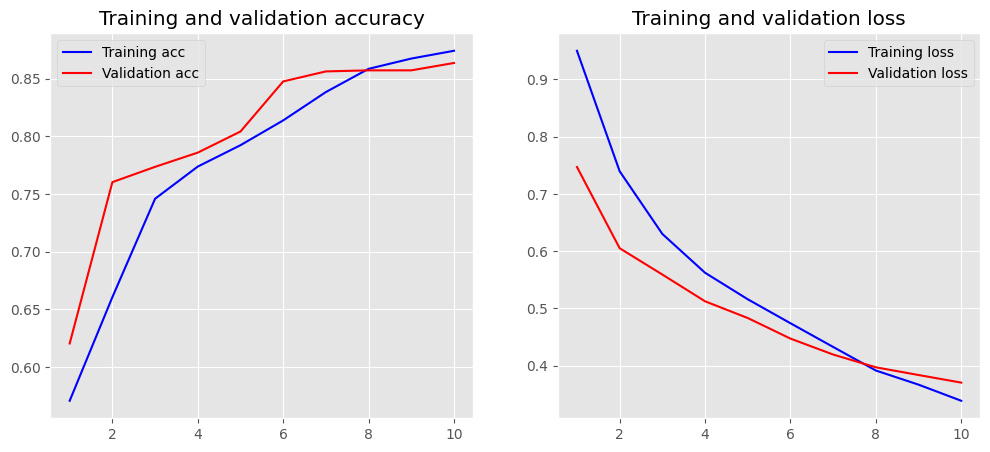

In [30]:
### Visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [31]:
model.save('model.h5')
print("Model has created!")

Model has created!


In [32]:
### Predict

import re
from keras.models import load_model

input_text = """
hormati partai-partai yang telah berkoalisi.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Text:   hormati partai partai yang telah berkoalisi  
Sentiment:  neutral


In [33]:
import re
from keras.models import load_model

input_text = """
sangat bagus sekali bro.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Text:   sangat bagus sekali bro  
Sentiment:  negative


In [34]:
import re
from keras.models import load_model

input_text = """
jelek sekali sifat murid itu, dia selalu membuli temannya.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Text:   jelek sekali sifat murid itu  dia selalu membuli temannya  
Sentiment:  negative
